# Phish Setlist Generator
## By Kenny Callaghan

&nbsp;

## Introduction: Problem

Phish is an American rock band formed in 1983 in Burlington, VT. Over the course of their 30+ years of prolific touring, the band has gained a reputation for their whimsical sense of humor, whacky onstage antics, and virtuistic instrumental improvisation. All of this has underscored the quintessential aspect of a Phish concert: every show is unique, and no two shows are quite the same. The easiest way to ensure this is to develop a unique setlist (ordered set) of songs for each of their 1700+ shows. When a show begins, no one can be sure what songs will be played - not even the members of the band themselves! What if there was a way to predict a setlist before-hand?

## Solution

We would like to create an algorithm that can create Phish setlists from scratch - without any input from the band. We could do this by assembling a random list of songs, but we can do better. We can inform what song comes next in a setlist by looking at historical setlist data and extrapolating from there. We can start with a randomly-chosen song, either from a list of all previously-played songs, or from a smaller pool of all songs that have been used before as a set-opener. Then we can use a Natural Language Processing (NLP) machine learning algorithm to predict the next songs that can be played in the setlist - similar to the word prediction system that is used by Google and other services to autocomplete searches or messages. The model will look at an ordered list of songs of a chosen LENGTH, and use that to predict which songs are likely to come next. The model is a Long Short Term Memory (LSTM) network which is a type of Recurrent Neural Network (RNN). The model will be trained on 80% of existing Phish setlists, adjusting the weights of the feature parameters as it works through the training set. Then, the model will be tested against the remaining 20% of setlists to determine how accurate it's prediction is. Once we are able to predict a subsequent song given a sequence of songs, we can begin to generate setlists from scratch, generating predictions based off of the existing setlist.

In [127]:
# This code will help for later

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import pickle
import heapq

## Data

The dataset we are using is the entire record of every live performance from the band. This data was scraped from phish.net, a fan-run site that keeps detailed records of everything Phish-related. The data was then sanitized and input into a sqlite database with a schema in Third Normal Form. The code for this process can be found at this public github repository: https://github.com/kcallaghan1/Phish-DB. The final step, was to output the view of ("setInfo" \[SET 1, SET 2, ENCORE\], "songTitle") into a text document "setSongs.txt". We can then run the following cell to remove the setInfo from in front of a songTitle, and include it in the list of songs, as if it were a song itself. This is done to create context in a sublist of songs randomly selected from the dataset.

In [2]:
fr = open("setSongs.txt", "r")
fw = open("songList.txt", "w")
lines = fr.readlines()

setInfo = ""
for i in range(1, len(lines)):
    line = lines[i]
    first, second = line.split(",", 1)

    if("\"" not in first):
        first = "\"" + first + "\""
    if(setInfo != first):
        if(first == "\"SET 1\""):
            fw.write("\"END\"\n")
        setInfo = first
        if("\"" not in setInfo):
            setInfo = "\"" + first + "\""
        fw.write(setInfo + "\n")
    if("\"" not in second):
        second = "\"" + second[0: len(second)-1] + "\"\n"
    fw.write(second)

fr.close()
fw.close()

fr = open("songList.txt", "r")
songs = fr.readlines()
songs = songs[1:len(songs) - 1]
songs.append("\"More\"\n")
songs.append("\"END\"\n")
fr.close()

print(songs)

['"SET 1"\n', '"Long Cool Woman in a Black Dress"\n', '"Proud Mary"\n', '"In the Midnight Hour"\n', '"Squeeze Box"\n', '"Roadhouse Blues"\n', '"Happy Birthday to You"\n', '"SET 2"\n', '"Scarlet Begonias"\n', '"Fire on the Mountain"\n', '"END"\n', '"SET 1"\n', '"Makisupa Policeman"\n', '"In the Midnight Hour"\n', '"Wild Child"\n', '"Jam"\n', '"Bertha"\n', '"Can\'t You Hear Me Knocking"\n', '"St. Stephen Jam"\n', '"Can\'t You Hear Me Knocking"\n', '"Camel Walk"\n', '"Eyes of the World"\n', '"Whipping Post"\n', '"Drums"\n', '"Jam"\n', '"Wild Child"\n', '"Bertha"\n', '"Can\'t You Hear Me Knocking"\n', '"Camel Walk"\n', '"Jam"\n', '"In the Midnight Hour"\n', '"Scarlet Begonias"\n', '"Fire"\n', '"Fire on the Mountain"\n', '"Makisupa Policeman"\n', '"Slave to the Traffic Light"\n', '"Spanish Flea"\n', '"Don\'t Want You No More"\n', '"Cities"\n', '"Drums"\n', '"Skippy the Wondermouse"\n', '"Fluffhead"\n', '"ENCORE"\n', '"Eyes of the World"\n', '"END"\n', '"SET 1"\n', '"Slave to the Traffic Lig

### Enumerating songs
Next, we will need to create a sorted array of unique songs that we can index and use in our model.

In [3]:
unique_songs = np.unique(songs)
unique_song_index = dict((c,i) for i, c in enumerate(unique_songs))

### Splitting the Data

This code will run through the entire dataset, sending 80% of concert setlists to the training set, and the remaining 20% to the test set. Because the popularity of certain songs changes over the years, we wouldn't want to take the first 80% of setlists, because that would unfairly represent setlists from the earlier years of the band's tenure, and would fail to represent setlist choices from the tours of the past few years. To compensate, we will iterate through the setlists chronologically, counting to 10, and sending every 9th and 10th setlist into the test set. 

In [4]:
training_set = []
test_set = []

concert = 0
for i in range(len(songs)):
    if(concert % 10 < 8):
        training_set.append(songs[i])
    else:
        test_set.append(songs[i])
    if(songs[i] == "\"END\"\n"):
        concert += 1

print(training_set)
print(test_set)

['"SET 1"\n', '"Long Cool Woman in a Black Dress"\n', '"Proud Mary"\n', '"In the Midnight Hour"\n', '"Squeeze Box"\n', '"Roadhouse Blues"\n', '"Happy Birthday to You"\n', '"SET 2"\n', '"Scarlet Begonias"\n', '"Fire on the Mountain"\n', '"END"\n', '"SET 1"\n', '"Makisupa Policeman"\n', '"In the Midnight Hour"\n', '"Wild Child"\n', '"Jam"\n', '"Bertha"\n', '"Can\'t You Hear Me Knocking"\n', '"St. Stephen Jam"\n', '"Can\'t You Hear Me Knocking"\n', '"Camel Walk"\n', '"Eyes of the World"\n', '"Whipping Post"\n', '"Drums"\n', '"Jam"\n', '"Wild Child"\n', '"Bertha"\n', '"Can\'t You Hear Me Knocking"\n', '"Camel Walk"\n', '"Jam"\n', '"In the Midnight Hour"\n', '"Scarlet Begonias"\n', '"Fire"\n', '"Fire on the Mountain"\n', '"Makisupa Policeman"\n', '"Slave to the Traffic Light"\n', '"Spanish Flea"\n', '"Don\'t Want You No More"\n', '"Cities"\n', '"Drums"\n', '"Skippy the Wondermouse"\n', '"Fluffhead"\n', '"ENCORE"\n', '"Eyes of the World"\n', '"END"\n', '"SET 1"\n', '"Slave to the Traffic Lig

## Model Parameters

Here is a list of parameters that can be useful to modify that will have impact on the speed and accuracy of the model.

In [90]:
# The length of the song sequence that the model will look at to predict the next song.
SEQ_LENGTH = 5

# Number of nodes in the LSTM layer
LSTM_NODES = 128

# Number of epochs - how many times the layers are passed through (forward + backwards = 1 epoch)
NUM_EPOCHS = 2

# Learning Rate
LR = 0.01

## Features

We create two features X, containing a sequence of given length songs, and Y, the subsequent song, or target value.

In [91]:
prev_songs = []
next_songs = []
for i in range(len(training_set) - SEQ_LENGTH):
    prev_songs.append(training_set[i:i + SEQ_LENGTH])
    next_songs.append(training_set[i + SEQ_LENGTH])

X = np.zeros((len(prev_songs), SEQ_LENGTH, len(unique_songs)), dtype = bool)
Y = np.zeros((len(next_songs), len(unique_songs)), dtype = bool)

for i, each_songs in enumerate(prev_songs):
    for j, each_song in enumerate(each_songs):
        X[i, j, unique_song_index[each_song]] = 1
    Y[i, unique_song_index[next_songs[i]]] = 1

## Model Creation

Our model is a single-layer LSTM model with a number of nodes that can be specified above, a dense-layer (layer of fully-connected nodes), and an activation layer using a softmax (generalized sigmoid) function.

In [92]:
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=(SEQ_LENGTH, len(unique_songs))))
model.add(Dense(len(unique_songs)))
model.add(Activation("softmax"))

## Training the Model

Next, we train the model using an RMSprop optimizer, which is similar the gradient descent algorithm. Our learning rate is set by the LR parameter defined above.

In [93]:
optimizer = RMSprop(LR)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs = NUM_EPOCHS, shuffle = True).history

Epoch 1/2
246/246 [==============================] - 11s 33ms/step - loss: 5.1117 - accuracy: 0.1126 - val_loss: 5.3407 - val_accuracy: 0.1598
Epoch 2/2
246/246 [==============================] - 7s 29ms/step - loss: 4.0841 - accuracy: 0.2139 - val_loss: 5.3808 - val_accuracy: 0.1659


Lastly, we can save the model and its history (containing an evaluation of the model's loss and accuracy) for future retreival using the following lines of code:

In [94]:
model.save("keras_next_song_model.h5")
pickle.dump(history, open("history.p", "wb"))

model = load_model("keras_next_song_model.h5")
history = pickle.load(open("history.p", "rb"))

## Using the Model to Generate Predicitons

Now that we have a trained model, we can use it to generate song predictions based on a subsequence of the test set. First, we use the prepare_input function to mark the indices corresponding to the songs contained in the sequence. Then, the sample function will select the indices with the highest probability of being chosen to be used for the prediction. Finally, the predict_completions function will map the predicted indices to a song and return the predictions.

In [144]:
def prepare_input(text, seq_length = SEQ_LENGTH):
    x = np.zeros((1, seq_length, len(unique_songs)))
    for t, song in enumerate(text):
        x[0, t, unique_song_index[song]] = 1
    return x


def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)


def predict_completions(text, n=3):
    x = prepare_input(text, n)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_songs[idx] for idx in next_indices]

We can use this code to randomly predict songs in the test set.

In [111]:
rand = np.random.randint(len(test_set))
q = test_set[rand:rand+SEQ_LENGTH]
seq = q[0:len(q) - 1 ]
print("Sequence: ", seq)
print("Correct song: ", q[SEQ_LENGTH - 1])
print("Next possible songs: ", predict_completions(seq, SEQ_LENGTH))

Sequence:  ['"Mike\'s Song"\n', '"The Horse"\n', '"Silent in the Morning"\n', '"Punch You in the Eye"\n']
Correct song:  "McGrupp and the Watchful Hosemasters"

Next possible songs:  ['"Weekapaug Groove"\n', '"ENCORE"\n', '"SET 2"\n', '"Hold Your Head Up"\n', '"SET 3"\n']


## Testing The Effect Various Parameters

Here, the code from above has been copied down to conveniently test the effects that changing various parameters has on the speed and accuracy of the model.

In [162]:
def create_and_evaluate_model(seq_length, lstm_nodes, num_epochs, lr):
    prev_songs = []
    next_songs = []
    for i in range(len(training_set) - seq_length):
        prev_songs.append(training_set[i:i + seq_length])
        next_songs.append(training_set[i + seq_length])

    X = np.zeros((len(prev_songs), seq_length, len(unique_songs)), dtype = bool)
    Y = np.zeros((len(next_songs), len(unique_songs)), dtype = bool)

    for i, each_songs in enumerate(prev_songs):
        for j, each_song in enumerate(each_songs):
            X[i, j, unique_song_index[each_song]] = 1
        Y[i, unique_song_index[next_songs[i]]] = 1

    model = Sequential()
    model.add(LSTM(lstm_nodes, input_shape=(seq_length, len(unique_songs))))
    model.add(Dense(len(unique_songs)))
    model.add(Activation("softmax"))


    optimizer = RMSprop(lr)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs = num_epochs, shuffle = True).history

    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    correct = 0
    for i in range(seq_length,len(test_set) - seq_length):
        q = test_set[i:i+seq_length + 1]
        seq = q[0:len(q)-1]
        predicted_songs = predict_completions(seq, seq_length)
        if(q[len(q)-1] in predicted_songs):
            correct += 1
    print("Guessed", correct, "correct out of", len(test_set) - seq_length) 
        


10. LR = 0.001:
Epoch 1/2
246/246 [==============================] - 10s 32ms/step - loss: 5.6307 - accuracy: 0.0489 - val_loss: 6.0575 - val_accuracy: 0.0981
Epoch 2/2
246/246 [==============================] - 7s 29ms/step - loss: 5.0534 - accuracy: 0.1043 - val_loss: 5.9492 - val_accuracy: 0.1386


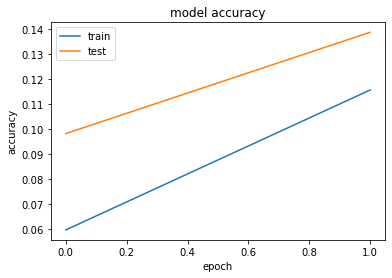

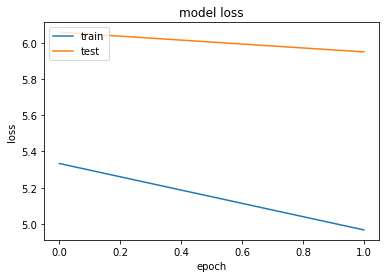

Guessed 18 correct out of 8217


In [161]:
# The length of the song sequence that the model will look at to predict the next song.
SEQ_LENGTH = 5

# Number of nodes in the LSTM layer
LSTM_NODES = 128

# Number of epochs - how many times the layers are passed through (forward + backwards = 1 epoch)
NUM_EPOCHS = 2

# Learning Rate
LR = 0.01

# Testing various values:
print("1. Default values:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, NUM_EPOCHS, LR)
print("2. SEQ_LENGTH = 10:")
create_and_evaluate_model(10, LSTM_NODES, NUM_EPOCHS, LR)
print("3. SEQ_LENGTH = 20:")
create_and_evaluate_model(20, LSTM_NODES, NUM_EPOCHS, LR)
print("4. LSTM_NODES = 50:")
create_and_evaluate_model(SEQ_LENGTH, 50, NUM_EPOCHS, LR)
print("5. LSTM_NODES = 150:")
create_and_evaluate_model(SEQ_LENGTH, 50, NUM_EPOCHS, LR)
print("6. NUM_EPOCHS = 5:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, 5, LR)
print("7. NUM_EPOCHS = 10:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, 10, LR)
print("8. NUM_EPOCHS = 20:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, 20, LR)
print("9. LR = 0.1:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, NUM_EPOCHS, 0.1)
print("10. LR = 0.001:")
create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, NUM_EPOCHS, 0.001)

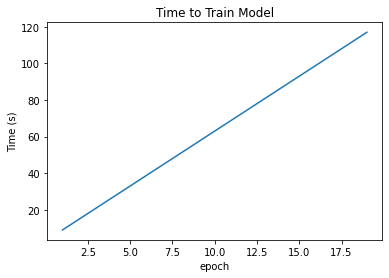

In [181]:
epoch_num = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
epoch_time = [9, 21, 33, 45, 57, 69, 81, 93, 105, 117]
plt.plot(epoch_num, epoch_time)
plt.title('Time to Train Model')
plt.ylabel('Time (s)')
plt.xlabel('epoch')
plt.show()

Additionally, we can see from this graph above that the time to train the model increases linearly with the number of passes completed through the neural network.

Now, we are going to use the following values for our parameters:

Epoch 1/20
246/246 [==============================] - 9s 29ms/step - loss: 5.6793 - accuracy: 0.0502 - val_loss: 5.9622 - val_accuracy: 0.0805
Epoch 2/20
246/246 [==============================] - 6s 24ms/step - loss: 5.0932 - accuracy: 0.0865 - val_loss: 5.8209 - val_accuracy: 0.1374
Epoch 3/20
246/246 [==============================] - 6s 24ms/step - loss: 4.7624 - accuracy: 0.1386 - val_loss: 5.6149 - val_accuracy: 0.1489
Epoch 4/20
246/246 [==============================] - 6s 24ms/step - loss: 4.5648 - accuracy: 0.1598 - val_loss: 5.4905 - val_accuracy: 0.1616
Epoch 5/20
246/246 [==============================] - 6s 24ms/step - loss: 4.3991 - accuracy: 0.1777 - val_loss: 5.4596 - val_accuracy: 0.1659
Epoch 6/20
246/246 [==============================] - 6s 25ms/step - loss: 4.3095 - accuracy: 0.1835 - val_loss: 5.4483 - val_accuracy: 0.1683
Epoch 7/20
246/246 [==============================] - 6s 25ms/step - loss: 4.2147 - accuracy: 0.1914 - val_loss: 5.4339 - val_accuracy: 0.1695

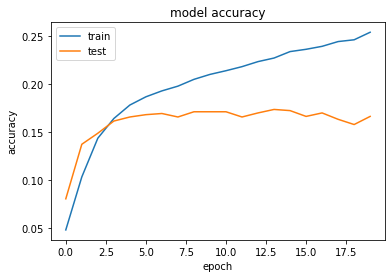

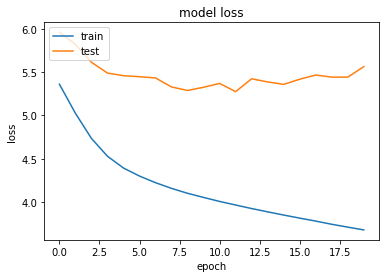

Guessed 2856 correct out of 8217


In [164]:
# The length of the song sequence that the model will look at to predict the next song.
SEQ_LENGTH = 5

# Number of nodes in the LSTM layer
LSTM_NODES = 100

# Number of epochs - how many times the layers are passed through (forward + backwards = 1 epoch)
NUM_EPOCHS = 20

# Learning Rate
LR = 0.001

create_and_evaluate_model(SEQ_LENGTH, LSTM_NODES, NUM_EPOCHS, LR)

When looking at the model's performance on the test set, we see that it always has a high loss and accuracy does not seem to be affected by the various parameters we modified. When runnning the model on the test set, we see that the prediction contained the actual next song 2856 out of 8217 times, for a test accuracy of ~35%.

## The Setlist Generator

We will use the final model with the parameters above to create the setlist generator. We start the setlist as every set should start - by annotating the beginning of the first set. The generator uses the last LENGTH songs from the setlist (or the entire setlist if it is smaller than LENGTH), and will select songs randomly from the set of predicted songs to append to the setlist. The generator will continue to generate values until it reaches a random limit (15-25, the range of an average Phish setlist), or "END", marking the end of the show.

In [178]:
def generate_setlist():
    setlist = []
    rand = np.random.randint(len(songs))
    setlist.append("\"SET 1\"\n")
    idx = 1
    go = True
    limit = np.random.randint(15) + 10
    while(go and idx < limit):
        rand = np.random.randint(SEQ_LENGTH)
        if(idx < SEQ_LENGTH):
            new_songs = predict_completions(setlist[0:idx], SEQ_LENGTH)
            new_song = new_songs[rand]
        else:
            new_songs = predict_completions(setlist[idx - SEQ_LENGTH: idx + SEQ_LENGTH], SEQ_LENGTH)
            new_song = new_songs[rand]
        setlist.append(new_song)
        if(new_song == "\"END\"\n"):
            go = False
        idx += 1
    return setlist

print(generate_setlist())

['"SET 1"\n', '"Divided Sky"\n', '"Stash"\n', '"Sparkle"\n', '"I Didn\'t Know"\n', '"Split Open and Melt"\n', '"The Lizards"\n', '"Run Like an Antelope"\n', '"SET 2"\n', '"Wilson"\n', '"Mike\'s Song"\n', '"Simple"\n', '"Simple"\n', '"Mike\'s Song"\n', '"Weekapaug Groove"\n', '"SET 2"\n', '"Mike\'s Song"\n', '"I Am Hydrogen"\n']


In [182]:
for i in range(10):
    print(generate_setlist())

['"SET 1"\n', '"Water in the Sky"\n', '"Taste"\n', '"Scent of a Mule"\n', '"Stash"\n', '"Fee"\n', '"Maze"\n', '"Strange Design"\n', '"Run Like an Antelope"\n', '"Golgi Apparatus"\n', '"SET 3"\n', '"Also Sprach Zarathustra"\n', '"Mike\'s Song"\n', '"Mike\'s Song"\n', '"Mike\'s Song"\n', '"Simple"\n', '"I Am Hydrogen"\n', '"Weekapaug Groove"\n']
['"SET 1"\n', '"Divided Sky"\n', '"Stash"\n', '"Stash"\n', '"Maze"\n', '"I Didn\'t Know"\n', '"Run Like an Antelope"\n', '"SET 2"\n', '"Also Sprach Zarathustra"\n', '"Mike\'s Song"\n', '"I Am Hydrogen"\n']
['"SET 1"\n', '"Funky Bitch"\n', '"David Bowie"\n', '"Alumni Blues"\n', '"Alumni Blues"\n', '"Run Like an Antelope"\n', '"SET 3"\n', '"Corinna"\n', '"Alumni Blues"\n', '"The Lizards"\n', '"Mike\'s Song"\n', '"Alumni Blues"\n', '"Letter to Jimmy Page"\n', '"END"\n']
['"SET 1"\n', '"Water in the Sky"\n', '"Scent of a Mule"\n', '"Taste"\n', '"Strange Design"\n', '"Taste"\n', '"ENCORE"\n', '"Suzy Greenberg"\n', '"Rocky Top"\n', '"Tweezer Reprise"\n

## Conclusion

After testing the final model against the test set, we found that the correct subsequent song was present in the list of length 5 about 35% of the time, which is significantly greater than if 5 songs were to be chosen at random from the 950 songs that are in Phish's live catalogue. However, when looking at the actual accuracy of the model on the test set, the results become less impressive, as the accuracy falls to 26%.

When looking at the setlists generated by the final function, some of them appear to be very passable as legitimate Phish setlists. However, some quirks in other entries become immediately apparent: the duplicate entries (songs are allowed to appear on a setlist two or more times (with anything greater than three being an extreme rarity), however a song will never appear twice consecutively) and the seemingly random placement of the set-indicators (causing severe inequality between sets: set 1 may contain 80% of the songs while set 2 may only have a couple of songs; not all sets made equal and sometimes one set may have significantly more songs than another set at the same show, but never to this extreme). The model's accuracy value as well as looking at the randomly generated setlists myself has led me to this conclusion: the model is competent at recognizing certain patterns in setlist and set construction (certain songs always following each other- "I am Hydrogen">"Weekapaug Groove", an encore will usually have one or two songs before show END). But, when looking at the dataset as a whole - setlist entries are too random or perhaps the dataset is not large enough to come to any reliable predictor of the bands setlists.

If I were to complete this project again, I would try to factor location and date of shows into the likelihood that a certain song will be played. As it stands now, the model is only looking for patterns in sequencing, but adding location and date data could be immensely helpful in clustering songs. Location would be useful for songs like "Fluffhead", which is performed more often at shows in New York City/State due to the lyric "Fluff Came To New York" provoking a cheer from the audience. For date, there are certain songs that were performed often in the past but infrequently now, or vice-versa (a song they may have just written, for example). These were all factors that I considered when originally brainstorming ideas for this project, however I unfortunately had to cut those aspects in order for this project to fit in a realistic time window and exist at a level of complexity that I was comfortable working on. This is a project and a topic that has inspired me, and I hope to return and improve upon it once I have more experience in the field of machine learning. Until then, only Phish can create Phish setlists.